In [1]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw

In [2]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.100.2


In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os
import subprocess
import sys
from matplotlib import gridspec

import warnings
warnings.simplefilter("ignore")

# %matplotlib widget

In [4]:
def extract_timing_ephys(base_dir,ttl_dir):    
    timefile = ttl_dir / 'timestamps.npy'
    statefile = ttl_dir / 'states.npy'
    outfile = base_dir / 'timestamps.data'
    
    a = np.load(timefile)
    b = np.load(statefile)
    
    c = a[b==1]
    c.shape = (c.size,1)
    
    d = (a[b==-1]-a[b==1])*1000
    d.shape = (d.size,1)
    
    np.savetxt(outfile,np.hstack([c,d]),fmt='%.6f,%.1f')

In [5]:
base_folder = Path("D:/HexinData/Dylan_2024-03-19_14-42-22_HPC/Record Node 113/experiment1/recording1")
header_file = base_folder / 'structure.oebin'
session_file = list(base_folder.glob("*.sqlite"))[0]
timestamp_file = base_folder / 'timestamps.data'
alignment_file = base_folder / 'alignmentinfo_README.txt'

with open(header_file) as file_:
    header_data = json.load(file_)
    
data_path = base_folder / 'continuous' / header_data['continuous'][0]['folder_name'] / 'continuous.dat'
ttl_path = base_folder / 'events' / header_data['events'][0]['folder_name']
nchannels = header_data['continuous'][0]['num_channels']
sample_rate = header_data['continuous'][0]['sample_rate']
chan_ids = [0]*nchannels

# This assumes the open ephys header format where channels are named "CH1", "CH2", ... , "CHn"
for index, channel in enumerate(header_data['continuous'][0]['channels']):
    chan_ids[index] = int(channel['channel_name'][2:])-1

sorting_alg = 'kilosort2'

In [6]:
recording_raw = si.read_binary(file_paths=data_path,sampling_frequency=sample_rate,dtype='int16',num_chan=nchannels)

In [7]:
recording_raw.annotate(is_filtered=False)

In [8]:
channel_ids = recording_raw.get_channel_ids()
fs = recording_raw.get_sampling_frequency()
num_chan = recording_raw.get_num_channels()
num_segments = recording_raw.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 30000.0
Number of channels: 64
Number of segments: 1


In [9]:
recording_f = spre.bandpass_filter(recording_raw, freq_min=300, freq_max=6000)
# will cmr remove the signal of spikes?
recording_cmr = spre.common_reference(recording_f, reference='global', operator='median')

In [10]:
recording_car = spre.common_reference(recording_f, reference='global', operator='average')

In [11]:
recording_raw.get_num_frames()

147816263

In [32]:
from scipy import signal

In [39]:
sos = signal.butter(1, 500, btype='lowpass',output='sos',fs=30000)
filtered = signal.sosfilt(sos, traces_raw[100000:110000,ch])

NameError: name 'filtered' is not defined

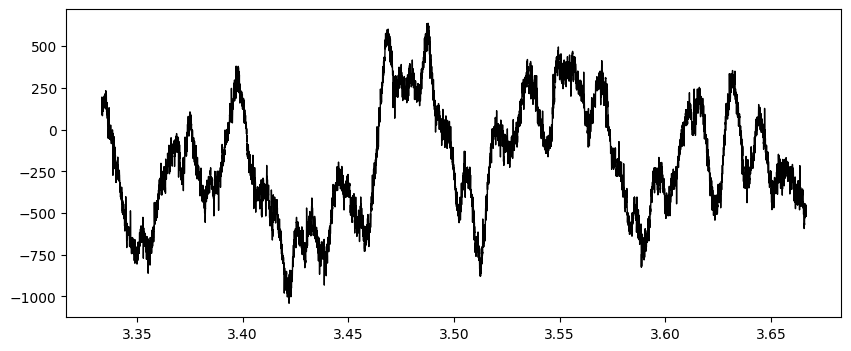

In [18]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(100000,110000)/fs,traces_raw[100000:110000,ch],'k-',lw=1)
plt.plot(np.arange(100000,110000)/fs,filtered,'r-',lw=1)

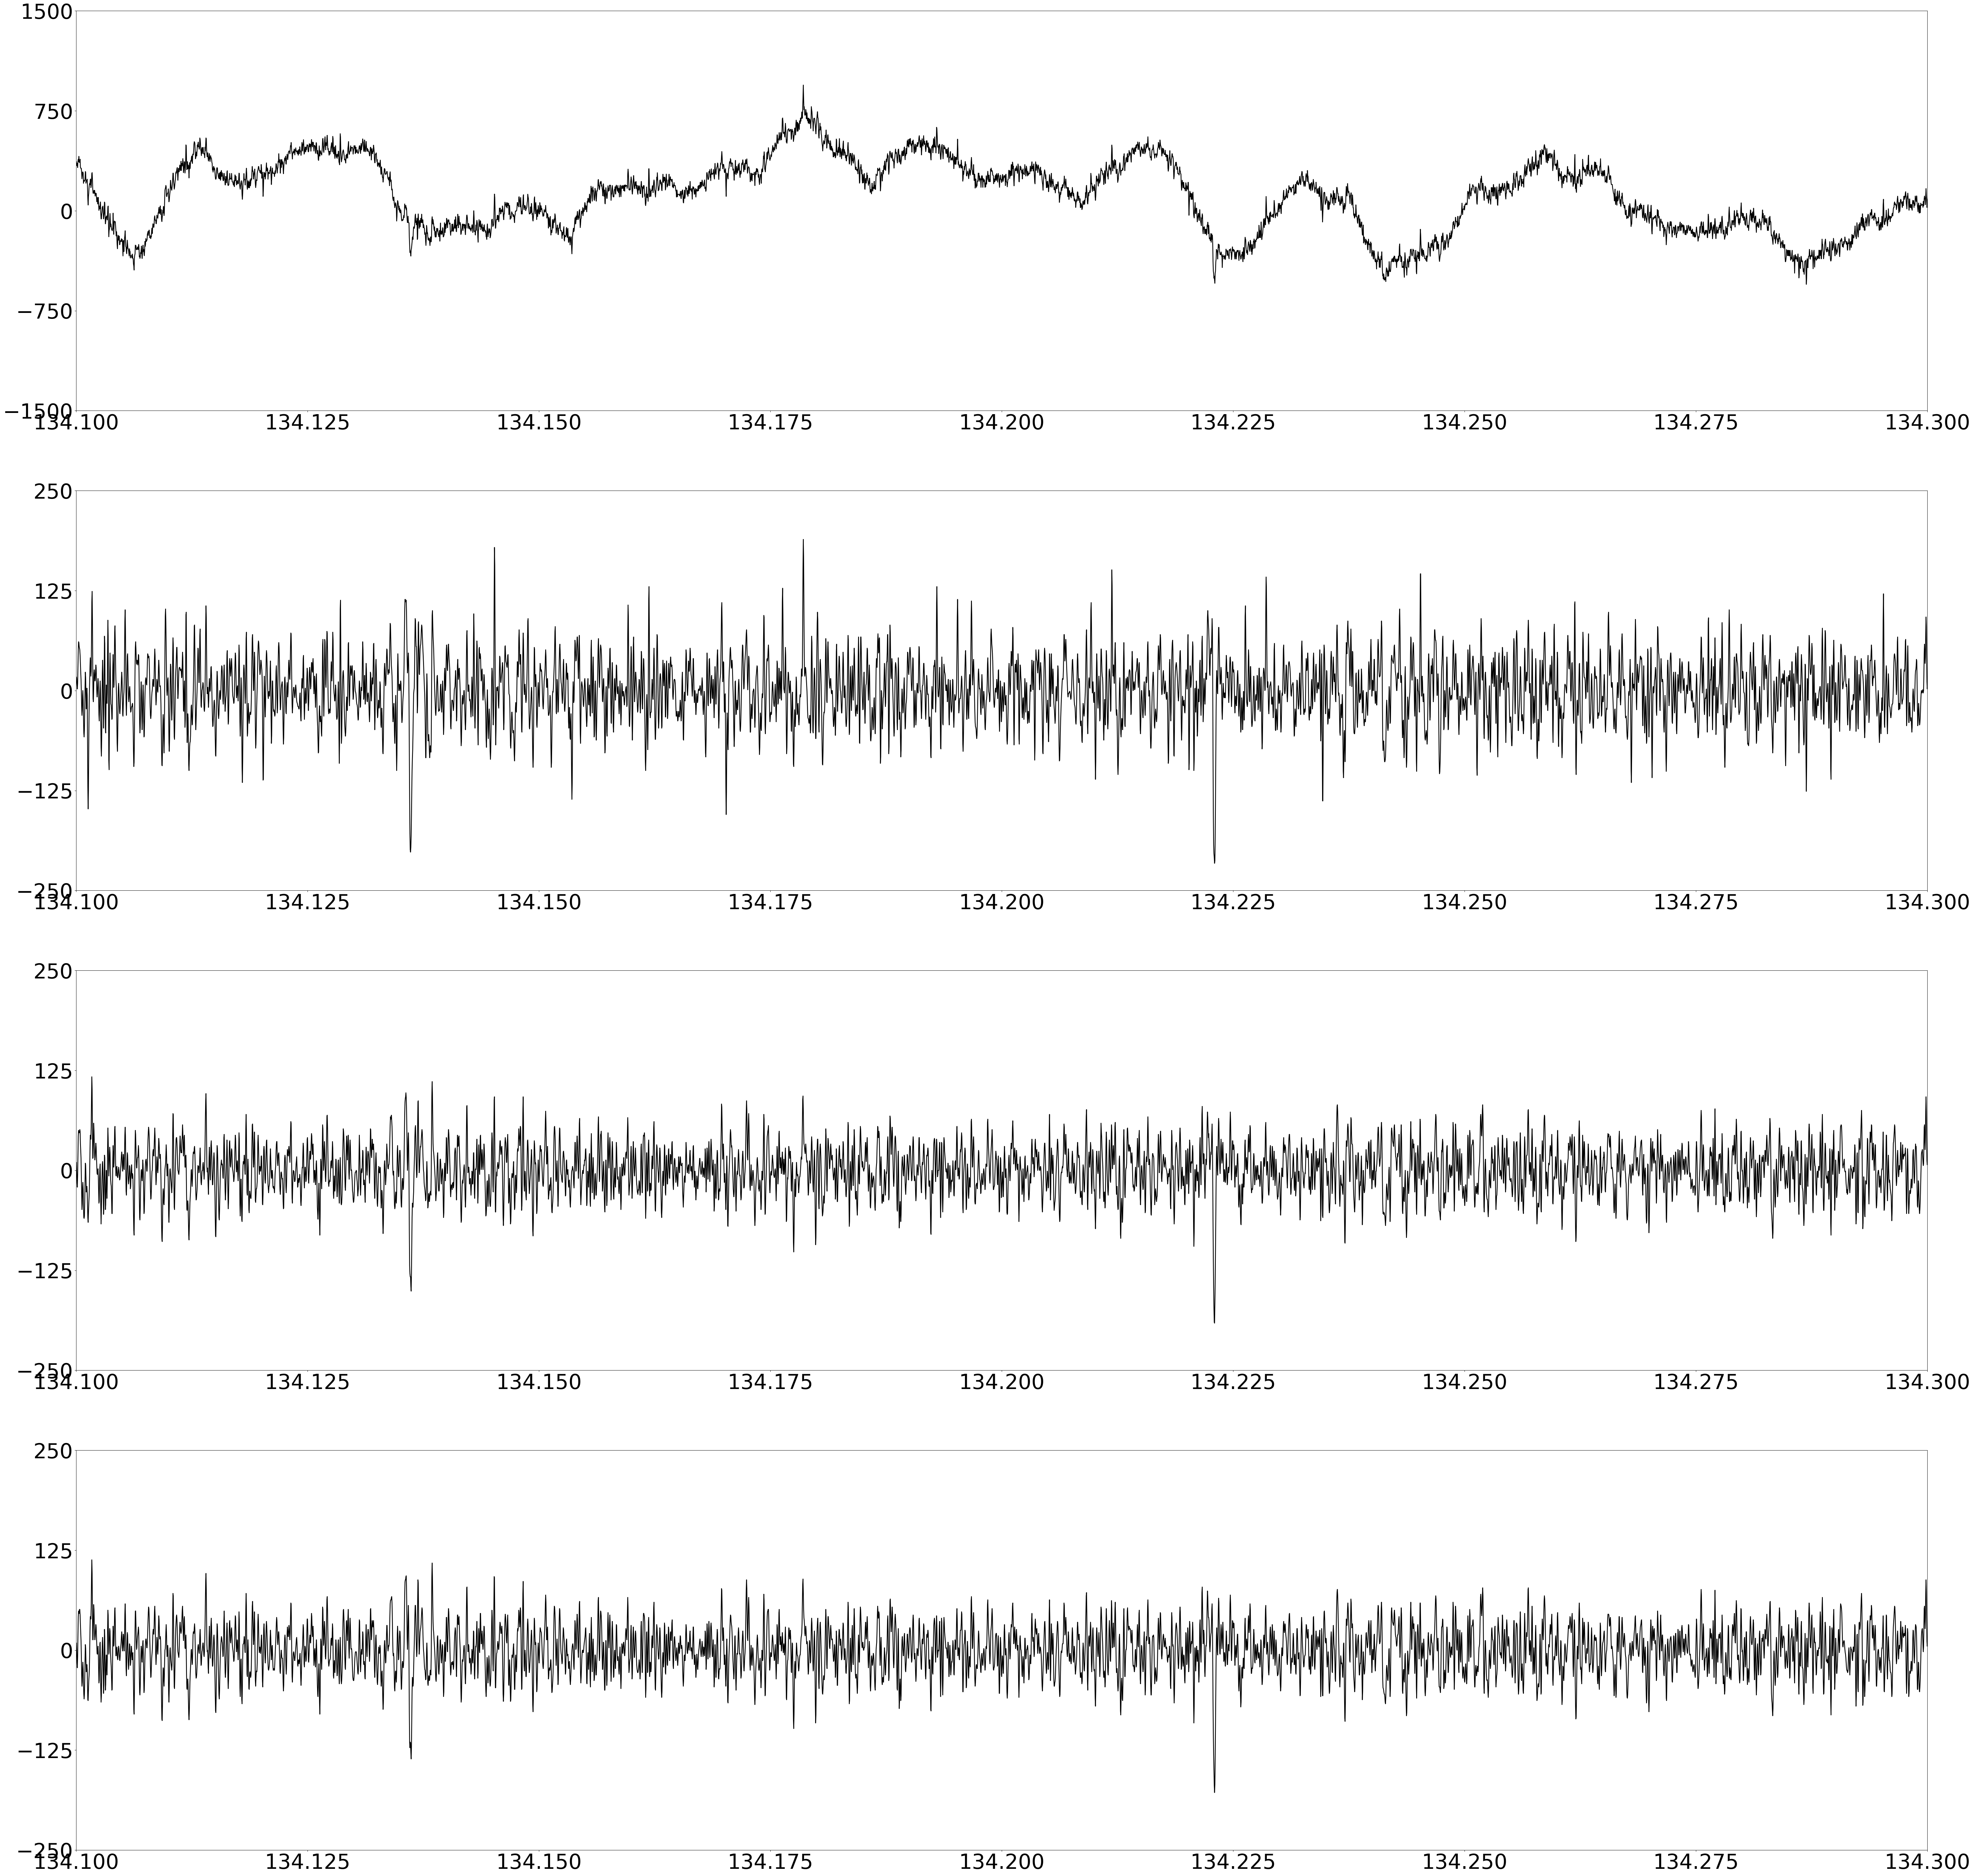

In [59]:
starttime=2*60+15.6-2
endtime=2*60+15.6
traces_raw = recording_raw.get_traces(start_frame=int(starttime*fs), end_frame=int(endtime*fs))
traces_f = recording_f.get_traces(start_frame=int(starttime*fs), end_frame=int(endtime*fs))
traces_cmr = recording_cmr.get_traces(start_frame=int(starttime*fs), end_frame=int(endtime*fs))
traces_car = recording_car.get_traces(start_frame=int(starttime*fs), end_frame=int(endtime*fs))
traces_time = recording_raw.get_times()[int(starttime*fs):int(endtime*fs)]

# for ch in range(34,35):
ch=28
plt.close('all')
plt.figure(figsize=(80,80))
gs = gridspec.GridSpec(4, 1) 

ax = plt.subplot(gs[0])
plt.plot(traces_time,traces_raw[:,ch],'k-',lw=2)
plt.ylim(-1500,1500)
plt.yticks(np.linspace(-1500,1500,5),fontsize=50)
plt.xticks(fontsize=50)
plt.xlim(134.1,134.3)

ax = plt.subplot(gs[1])
plt.plot(traces_time,traces_f[:,ch],'k-',lw=2)
plt.ylim(-250,250)
plt.yticks(np.linspace(-250,250,5),fontsize=50)
plt.xticks(fontsize=50)
plt.xlim(134.1,134.3)

ax = plt.subplot(gs[2])
plt.plot(traces_time,traces_cmr[:,ch],'k-',lw=2)
plt.yticks(np.linspace(-250,250,5),fontsize=50)
plt.ylim(-250,250)
plt.xticks(fontsize=50)
plt.xlim(134.1,134.3)

ax = plt.subplot(gs[3])
plt.plot(traces_time,traces_car[:,ch],'k-',lw=2)
plt.yticks(np.linspace(-250,250,5),fontsize=50)
plt.ylim(-250,250)
plt.xticks(fontsize=50)
plt.xlim(134.1,134.3)
plt.savefig('20240320_ch' + str(ch+1) + 'lfp.png')

In [12]:
fs = recording_f.get_sampling_frequency()

#recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=1500*fs)
recording_sub = recording_f
recording_sub

BandpassFilterRecording: 64 channels - 30.0kHz - 1 segments - 147,816,263 samples 
                         4,927.21s (1.37 hours) - int16 dtype - 17.62 GiB

In [13]:
job_kwargs = dict(n_jobs=10, chunk_duration="1s", progress_bar=True)

In [14]:
preprocessed_dir = base_folder / "preprocessed"

if preprocessed_dir.is_dir():
    recording_saved = si.load_extractor(preprocessed_dir)
else:
    recording_saved = recording_sub.save(folder=preprocessed_dir, **job_kwargs)

In [15]:
ss.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'kilosort4',
 'klusta',
 'mountainsort4',
 'mountainsort5',
 'pykilosort',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

In [50]:
ss.Kilosort3Sorter.set_kilosort3_path('D:\Kilosort-main\Kilosort-main')
ss.Kilosort2_5Sorter.set_kilosort2_5_path('D:\Kilosort-2.5')
ss.Kilosort2Sorter.set_kilosort2_path('D:\Kilosort-2.0\Kilosort-2.0')

Setting KILOSORT3_PATH environment variable for subprocess calls to: D:\Kilosort-main\Kilosort-main
Setting KILOSORT2_5_PATH environment variable for subprocess calls to: D:\Kilosort-2.5
Setting KILOSORT2_PATH environment variable for subprocess calls to: D:\Kilosort-2.0\Kilosort-2.0


In [51]:
ss.installed_sorters()

RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptdvnygnk7\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscripthhdk7pn8\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscripthf8mq_mm\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptmzdi5qn9\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscript74ysdsa2\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptkqynolji\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptuutneo33\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptmnhzb_cj\script.bat


['kilosort2', 'kilosort2_5', 'kilosort3', 'spykingcircus2', 'tridesclous2']

In [19]:
sorting_alg

'kilosort4'

In [20]:
ss.get_sorter_params_description(sorting_alg)

{'batch_size': 'Number of samples per batch. Default value: 60000.',
 'nblocks': 'Number of non-overlapping blocks for drift correction (additional nblocks-1 blocks are created in the overlaps). Default value: 1.',
 'Th_universal': 'Spike detection threshold for universal templates. Th(1) in previous versions of Kilosort. Default value: 9.',
 'Th_learned': 'Spike detection threshold for learned templates. Th(2) in previous versions of Kilosort. Default value: 8.',
 'do_CAR': 'Whether to perform common average reference. Default value: True.',
 'invert_sign': 'Invert the sign of the data. Default value: False.',
 'nt': 'Number of samples per waveform. Also size of symmetric padding for filtering. Default value: 61.',
 'artifact_threshold': 'If a batch contains absolute values above this number, it will be zeroed out under the assumption that a recording artifact is present. By default, the threshold is infinite (so that no zeroing occurs). Default value: None.',
 'nskip': 'Batch stride 

In [21]:
ss.get_default_sorter_params(sorting_alg)

{'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'do_CAR': True,
 'invert_sign': False,
 'nt': 61,
 'artifact_threshold': None,
 'nskip': 25,
 'whitening_range': 32,
 'binning_depth': 5,
 'sig_interp': 20,
 'nt0min': None,
 'dmin': None,
 'dminx': None,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_downsampling': 20,
 'cluster_pcs': 64,
 'duplicate_spike_bins': 15,
 'do_correction': True,
 'keep_good_only': False,
 'save_extra_kwargs': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None}

In [35]:
ss.run_sorter?

In [47]:
sorter_params = {'do_correction': False}

In [16]:
# poly3, ?? deeper is more positive or more negative 

# for layout, counting from the left to right, top to bottom
# col1: 0-20, col2: 21-42, col3: 43-63
layout = np.zeros((64,2))
ephys_config = np.zeros((64,2))

layout[0:21,0]=-25*np.sqrt(3)/2
layout[0:21,1]=-np.arange(21)*25-12.5
layout[21:43,0]=0
layout[21:43,1]=-np.arange(22)*25
layout[43:,0]=25*np.sqrt(3)/2
layout[43:,1]=-np.arange(21)*25-12.5

# mapping refers to how recording system channel maps on to the layout, this is said to be the wrong mapping....
# mapping 1
# mapping = np.array([8,9,11,12,14,15,31,32,30,27,28,25,26,23,24,21,22,19,20,17,18,
#           63,1,64,2,61,3,62,4,59,5,60,6,57,7,55,10,54,13,49,16,34,29,
#           58,56,53,51,52,50,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48])

# mapping 2
# mapping = np.array([40,41,43,44,46,47,63,64,62,59,60,57,58,55,56,53,54,51,52,49,50,
#                     31,33,32,34,29,35,30,36,27,37,28,38,25,39,23,42,22,45,17,48,2,61,
#                    26,24,21,19,20,18,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

mapping = np.array([55,58,60,59,61,64,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,
                   16,50,15,49,14,52,13,51,12,54,11,53,10,56,8,57,5,62,2,63,48,19,
                   9,7,6,4,3,1,47,45,46,43,44,41,42,39,40,37,38,35,36,33,34])


ephys_config[mapping-1,:]=layout

config_ = ephys_config

recording_saved.set_channel_locations(config_,channel_ids=chan_ids)

(-23.81569860407206, 23.81569860407206, -551.25, 26.25)

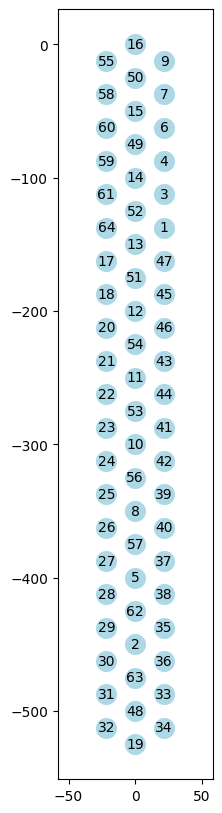

In [37]:
plt.close('all')
plt.figure(figsize=(2,10))

for ii in range(64):
    plt.scatter(ephys_config[ii,0],ephys_config[ii,1],200,marker='o',color='lightblue')
    plt.text(ephys_config[ii,0],ephys_config[ii,1],str(ii+1),ha='center',va='center')

plt.axis('equal')

In [18]:
sorting_alg = 'kilosort4'

output_folder = base_folder / 'output' / sorting_alg
    
sorting_output = ss.run_sorter(sorting_alg, recording_saved,
                             output_folder=output_folder,
                             verbose=True, **job_kwargs)


AttributeError: Bad parameters: ['n_jobs', 'chunk_duration', 'progress_bar']

In [66]:
# run spike sorting on entire recording
output_folder = base_folder / 'output' / sorting_alg
    
sorting_output = ss.run_sorter(sorting_alg, recording_saved,
                             output_folder=output_folder,
                             verbose=True, **job_kwargs)

# sorting_output = ss.run_sorter(sorting_alg, recording_saved,
#                              output_folder=output_folder,
#                              verbose=True,  **job_kwargs)

RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscripto7o6hnhi\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscript3z5rolth\script.bat
RUNNING SHELL SCRIPT: C:\Users\leelab\AppData\Local\Temp\tmp_shellscriptf21wjme8\script.bat
RUNNING SHELL SCRIPT: D:\HexinData\Dylan_2024-03-19_14-42-22_HPC\Record Node 113\experiment1\recording1\output\kilosort3\run_kilosort3.bat


C:\Users\leelab\Documents\GitHub\MazeTaskAnalysis>D:



D:\>cd D:\HexinData\Dylan_2024-03-19_14-42-22_HPC\Record Node 113\experiment1\recording1\output\kilosort3 



D:\HexinData\Dylan_2024-03-19_14-42-22_HPC\Record Node 113\experiment1\recording1\output\kilosort3>matlab -nosplash -wait -r "kilosort3_master('D:\HexinData\Dylan_2024-03-19_14-42-22_HPC\Record Node 113\experiment1\recording1\output\kilosort3', 'D:\Kilosort-main\Kilosort-main')" 

kilosort3 run time 1064.03s


In [60]:
if sorting_alg == 'kilosort2':
    # Update params.py to point to temp_wh.dat locally
    params_file = output_folder / 'params.py'
    
    with open(params_file,'r') as file_:
        params_ = file_.readlines()
    
    if params_:
        params_[0] = 'dat_path = \'temp_wh.dat\'\n'
        with open(params_file,'w') as file_:
            file_.writelines(params_)

    # Delete the unnecessary recording.dat if it exists
    tbd = output_folder / 'recording.dat'
    if os.path.exists(tbd):
        os.remove(tbd)

    # Extract phy waveforms
    phy_script = r'D:\SpikeInterface\run_phy.bat'
    subprocess.run([phy_script, output_folder])

    # Extract timing signal if not done already
    if not os.path.exists(timestamp_file):
        extract_timing_ephys(base_folder,ttl_path)
        # For neuropixels recordings, run the following line instead:
        # subprocess.run(['python','D:/SpikeInterface/extract_timing.py',data_path,str(sample_rate),str(nchannels),str(nchannels-1),"2"])

    # Align timing if not done already
    if not os.path.exists(alignment_file):
        subprocess.run(['D:/SpikeInterface/align_timestamps.exe',session_file,timestamp_file,alignment_file])
    

In [30]:
data = np.fromfile(output_folder /'temp_wh.dat', dtype=float)

In [28]:
spikes = np.load(output_folder / 'spike_times.npy')
clusters = np.load(output_folder / 'spike_clusters.npy')

In [14]:
output_folder = base_folder / 'output' / sorting_alg

model = load_model(output_folder / 'params.py')

In [25]:
# To Run Phy:
# Activate conda environment: 'conda activate phy2'
# Run phy: 'phy template-gui params.py'

In [ ]:
# db = sqlite3.connect('D:/HexinData/20240226_Dylan_Day1/Session_2024_01_03__13_22_47.sqlite')
# query = "SELECT aligncode,timestamp FROM behavioralalignevents ORDER BY aligneventnumber"
# cursor = db.cursor()
# a = np.array(cursor.execute(query).fetchall())
# b = np.array(pd.read_csv('D:/Recordings/2024-01-05_11-30-26/Record Node 113/experiment1/recording1/timestamps.data',header=None))

In [ ]:
# session = Session('D:\HexinData\2024-02-26_14-01-21')
# recording = session.recordnodes[0].recordings[0]
# samplesize = recording.continuous[0].samples.shape[0]
# chunksize=30000*60  ## 1 minute
# bins = int(np.floor(samplesize/chunksize))

In [ ]:
# Allspikes=[]

# for bb in range(bins):
    
#     voltage = recording.continuous[0].get_samples(start_sample_index=chunksize*bb, end_sample_index=chunksize*(bb+1))
#     ts = recording.continuous[0].timestamps[chunksize*bb:chunksize*(bb+1)]
#     x=voltage[:,16]
#     sos = signal.butter(10, 1000, btype='highpass',output='sos',fs=30000)
#     filtered = signal.sosfilt(sos, x)
#     spikes, _ = find_peaks(filtered, height=75,distance=100)
#     Allspikes=np.append(Allspikes,ts[spikes])
    
# Spikes_alinged=Allspikes*1.0000028-183.3522801